# Correlation Checker: Exposure Scores by Title and Seniority (EU vs USA)

This notebook computes the Pearson correlation between exposure scores for different job titles and seniority levels, comparing EU and USA data side by side.

**Data sources:**
- `data/Elondou/occ_level.csv` (columns: 'O*NET-SOC Code', 'dv_rating_beta')
- `data/Results/EU_occupation.parquet` (columns: 'onet_code', 'seniority', 'last_period_pct')
- `data/Results/USA_occupation.parquet` (columns: 'onet_code', 'seniority', 'last_period_pct')

**Goal:**
- For each seniority level (1-6), compute the Pearson correlation between `dv_rating_beta` and `last_period_pct` for matching O*NET codes.
- Compare EU and USA results side by side.

In [10]:
# Import required libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [ ]:
# Load data
occ_path = '../Data/pierre_occ_level.csv'
eu_path = '../Results/R_800_EU_occupation.parquet'
usa_path = '../Results/R_800_USA_occupation.parquet'

occ_df = pd.read_csv(occ_path)
eu_df = pd.read_parquet(eu_path)
usa_df = pd.read_parquet(usa_path)

# Show first few rows of each
print("Occupation data:")
display(occ_df.head())
print("\nEU data:")
display(eu_df.head())
print("\nUSA data:")
display(usa_df.head())

Occupation data:


,O*NET-SOC Code,Title,dv_rating_beta
0,11-1011.00,Chief Executives,0.451361
1,11-1011.03,Chief Sustainability Officers,0.422938
2,11-1021.00,General and Operations Managers,0.454609
3,11-2021.00,Marketing Managers,0.460273
4,11-2022.00,Sales Managers,0.406759



EU data:


,onet_code,seniority,avg_post_effect,last_period_coef,last_period_se,n_observations,n_firms,occupation_title,avg_post_pct,last_period_pct,last_period_ci_lower,last_period_ci_upper,last_period_significant,total_fte_weight,pct_change_final_vs_baseline
0,15-2041.00,6,0.621547,0.797443,0.299941,2552,44,Statisticians,86.180638,121.985838,0.209558,1.385328,True,1474.111505,75.646153
1,39-3031.00,3,0.590544,0.941196,0.362020,2030,35,"Ushers, Lobby Attendants, and Ticket Takers",80.496947,156.304448,0.231637,1.650755,True,1063.333054,148.093105
2,29-1221.00,4,0.568659,1.069390,0.314248,464,8,"Pediatricians, General",76.589810,191.360247,0.453464,1.685316,True,1206.520998,183.795579
3,19-4061.00,6,0.467370,0.667753,0.226730,2610,45,Social Science Research Assistants,59.579160,94.985114,0.223361,1.112145,True,2364.656659,124.972239
4,27-2021.00,3,0.460637,0.824844,0.252359,2378,41,Athletes and Sports Competitors,58.508271,128.152433,0.330221,1.319467,True,1851.540442,127.279746



USA data:


,onet_code,seniority,avg_post_effect,last_period_coef,last_period_se,n_observations,n_firms,occupation_title,avg_post_pct,last_period_pct,last_period_ci_lower,last_period_ci_upper,last_period_significant,total_fte_weight,pct_change_final_vs_baseline
0,15-2041.00,6,0.621547,0.797443,0.299941,2552,44,Statisticians,86.180638,121.985838,0.209558,1.385328,True,1474.111505,75.646153
1,39-3031.00,3,0.590544,0.941196,0.362020,2030,35,"Ushers, Lobby Attendants, and Ticket Takers",80.496947,156.304448,0.231637,1.650755,True,1063.333054,148.093105
2,29-1221.00,4,0.568659,1.069390,0.314248,464,8,"Pediatricians, General",76.589810,191.360247,0.453464,1.685316,True,1206.520998,183.795579
3,19-4061.00,6,0.467370,0.667753,0.226730,2610,45,Social Science Research Assistants,59.579160,94.985114,0.223361,1.112145,True,2364.656659,124.972239
4,27-2021.00,3,0.460637,0.824844,0.252359,2378,41,Athletes and Sports Competitors,58.508271,128.152433,0.330221,1.319467,True,1851.540442,127.279746


In [12]:
# Prepare and merge data for both EU and USA

# ============================================================================
# CONFIGURATION: Filter by statistical significance
# ============================================================================
# Set to True to ONLY include observations where last_period_significant == True
# Set to False to include ALL observations regardless of significance
FILTER_BY_SIGNIFICANCE = False
# ============================================================================

# Select relevant columns and rename for merging
occ_sel = occ_df[['O*NET-SOC Code', 'dv_rating_beta']].rename(columns={'O*NET-SOC Code': 'onet_code'})
occ_sel['onet_code'] = occ_sel['onet_code'].astype(str)

# Process EU data - include total_fte_weight for weighting and last_period_coef for transformation
eu_sel = eu_df[['onet_code', 'seniority', 'last_period_coef', 'last_period_pct', 'total_fte_weight', 
                 'last_period_se', 'last_period_ci_lower', 'last_period_ci_upper', 'last_period_significant']].copy()
eu_sel['onet_code'] = eu_sel['onet_code'].astype(str)
eu_sel = eu_sel[eu_sel['seniority'].isin([1,2,3,4,5,6])]

# Apply significance filter if enabled
if FILTER_BY_SIGNIFICANCE:
    eu_sel = eu_sel[eu_sel['last_period_significant'] == True]
    print(f"Filtering EU data by significance: {len(eu_sel)} rows remaining")

merged_eu = pd.merge(eu_sel, occ_sel, on='onet_code', how='inner')

# Process USA data - include total_fte_weight for weighting and last_period_coef for transformation
usa_sel = usa_df[['onet_code', 'seniority', 'last_period_coef', 'last_period_pct', 'total_fte_weight',
                   'last_period_se', 'last_period_ci_lower', 'last_period_ci_upper', 'last_period_significant']].copy()
usa_sel['onet_code'] = usa_sel['onet_code'].astype(str)
usa_sel = usa_sel[usa_sel['seniority'].isin([1,2,3,4,5,6])]

# Apply significance filter if enabled
if FILTER_BY_SIGNIFICANCE:
    usa_sel = usa_sel[usa_sel['last_period_significant'] == True]
    print(f"Filtering USA data by significance: {len(usa_sel)} rows remaining")

merged_usa = pd.merge(usa_sel, occ_sel, on='onet_code', how='inner')

# Show merged data
if FILTER_BY_SIGNIFICANCE:
    print(f"\n** FILTERING ENABLED: Only including statistically significant observations **\n")
else:
    print(f"\n** FILTERING DISABLED: Including all observations regardless of significance **\n")

print(f"EU merged data: {len(merged_eu)} rows")
display(merged_eu.head())

print(f"\nUSA merged data: {len(merged_usa)} rows")
display(merged_usa.head())


** FILTERING DISABLED: Including all observations regardless of significance **

EU merged data: 2643 rows


,onet_code,seniority,last_period_coef,last_period_pct,total_fte_weight,last_period_se,last_period_ci_lower,last_period_ci_upper,last_period_significant,dv_rating_beta
0,15-2041.00,6,0.797443,121.985838,1474.111505,0.299941,0.209558,1.385328,True,0.449162
1,39-3031.00,3,0.941196,156.304448,1063.333054,0.362020,0.231637,1.650755,True,0.408383
2,29-1221.00,4,1.069390,191.360247,1206.520998,0.314248,0.453464,1.685316,True,0.458900
3,19-4061.00,6,0.667753,94.985114,2364.656659,0.226730,0.223361,1.112145,True,0.528697
4,27-2021.00,3,0.824844,128.152433,1851.540442,0.252359,0.330221,1.319467,True,0.422152



USA merged data: 2643 rows


,onet_code,seniority,last_period_coef,last_period_pct,total_fte_weight,last_period_se,last_period_ci_lower,last_period_ci_upper,last_period_significant,dv_rating_beta
0,15-2041.00,6,0.797443,121.985838,1474.111505,0.299941,0.209558,1.385328,True,0.449162
1,39-3031.00,3,0.941196,156.304448,1063.333054,0.362020,0.231637,1.650755,True,0.408383
2,29-1221.00,4,1.069390,191.360247,1206.520998,0.314248,0.453464,1.685316,True,0.458900
3,19-4061.00,6,0.667753,94.985114,2364.656659,0.226730,0.223361,1.112145,True,0.528697
4,27-2021.00,3,0.824844,128.152433,1851.540442,0.252359,0.330221,1.319467,True,0.422152


In [13]:
# Verify that last_period_pct matches our transformation: 100*(exp(last_period_coef)-1)
# This ensures we're using consistent definitions throughout the notebook

print("Verifying y definition consistency:")
print("We use: y = 100*(exp(last_period_coef) - 1)")
print("\nChecking if last_period_pct matches this transformation...\n")

# Check EU data
eu_transformed = 100 * (np.exp(merged_eu['last_period_coef']) - 1)
eu_diff = np.abs(eu_transformed - merged_eu['last_period_pct'])
print(f"EU: Max difference between last_period_pct and transformation: {eu_diff.max():.6f}")
print(f"EU: Mean difference: {eu_diff.mean():.6f}")

# Check USA data  
usa_transformed = 100 * (np.exp(merged_usa['last_period_coef']) - 1)
usa_diff = np.abs(usa_transformed - merged_usa['last_period_pct'])
print(f"USA: Max difference between last_period_pct and transformation: {usa_diff.max():.6f}")
print(f"USA: Mean difference: {usa_diff.mean():.6f}")

if eu_diff.max() < 0.01 and usa_diff.max() < 0.01:
    print("\n✓ Confirmed: last_period_pct matches our transformation within numerical precision")
    print("  All correlations, CIs, and plots use the same y definition.")
else:
    print("\n⚠ Warning: last_period_pct does NOT match the transformation!")
    print("  We will use the transformed values from last_period_coef for all computations.")

Verifying y definition consistency:
We use: y = 100*(exp(last_period_coef) - 1)

Checking if last_period_pct matches this transformation...

EU: Max difference between last_period_pct and transformation: 0.000000
EU: Mean difference: 0.000000
USA: Max difference between last_period_pct and transformation: 0.000000
USA: Mean difference: 0.000000

✓ Confirmed: last_period_pct matches our transformation within numerical precision
  All correlations, CIs, and plots use the same y definition.


In [14]:
# Compute Pearson correlations with Monte Carlo propagation of measurement error
# Propagates uncertainty on coefficient scale: beta ~ N(beta_hat, se^2), then y = 100*(exp(beta)-1)

def _compute_mc_correlation(x, beta_hat, se_beta, weights=None, n_draws=5000, rng=None):
    """
    Helper: Compute MC median correlation and CI.
    
    Args:
        x: Fixed predictor values (e.g., dv_rating_beta)
        beta_hat: Point estimates of coefficients
        se_beta: Standard errors of coefficients
        weights: Optional weights for weighted correlation
        n_draws: Number of MC draws
        rng: Numpy random generator
    
    Returns:
        (mc_median, ci_lower, ci_upper, mc_se) or (nan, nan, nan, nan)
    """
    if rng is None:
        rng = np.random.default_rng(42)
    
    mc_corrs = []
    for _ in range(n_draws):
        # Draw from coefficient distribution
        beta_r = beta_hat + rng.normal(0, se_beta)
        # Transform to percent change
        y_r = 100 * (np.exp(beta_r) - 1)
        
        # Check for variability
        if np.std(y_r) == 0:
            continue
        
        # Compute correlation (weighted or unweighted)
        if weights is None:
            # Unweighted
            if len(np.unique(x)) < 2:
                continue
            corr_mc, _ = pearsonr(x, y_r)
        else:
            # Weighted
            wx_mean = np.average(x, weights=weights)
            wy_mean = np.average(y_r, weights=weights)
            cov = np.average((x - wx_mean) * (y_r - wy_mean), weights=weights)
            std_x = np.sqrt(np.average((x - wx_mean)**2, weights=weights))
            std_y = np.sqrt(np.average((y_r - wy_mean)**2, weights=weights))
            
            if std_x == 0 or std_y == 0:
                continue
            
            corr_mc = cov / (std_x * std_y)
        
        mc_corrs.append(corr_mc)
    
    if len(mc_corrs) > 0:
        mc_corrs = np.array(mc_corrs)
        mc_median = np.median(mc_corrs)
        ci_lower = np.percentile(mc_corrs, 2.5)
        ci_upper = np.percentile(mc_corrs, 97.5)
        mc_se = np.std(mc_corrs, ddof=1)
        return mc_median, ci_lower, ci_upper, mc_se
    else:
        return np.nan, np.nan, np.nan, np.nan


def compute_correlations_mc(merged_df, region_name, weighted=False, n_draws=5000, rng_seed=42):
    """
    Compute Pearson correlations with Monte Carlo confidence intervals.
    Reports MC median as point estimate.
    
    Args:
        merged_df: DataFrame with columns dv_rating_beta, last_period_coef, last_period_se, 
                   total_fte_weight (if weighted), seniority
        region_name: String identifier for the region
        weighted: If True, compute weighted correlation using total_fte_weight
        n_draws: Number of Monte Carlo draws for uncertainty propagation
        rng_seed: Random seed for reproducibility
    
    Returns:
        DataFrame with columns: region, seniority, correlation, ci_lower, ci_upper, mc_se, n
    """
    correlations = []
    rng = np.random.default_rng(rng_seed)
    
    for level in range(1, 7):
        df_level = merged_df[merged_df['seniority'] == level]
        n_obs = len(df_level)
        
        if n_obs < 2:
            correlations.append({
                'region': region_name,
                'seniority': level,
                'correlation': np.nan,
                'ci_lower': np.nan,
                'ci_upper': np.nan,
                'mc_se': np.nan,
                'n': n_obs
            })
            continue
        
        # Extract data
        x = df_level['dv_rating_beta'].values
        beta_hat = df_level['last_period_coef'].values
        se_beta = df_level['last_period_se'].values
        
        # Check for sufficient variability
        if len(np.unique(x)) < 2:
            correlations.append({
                'region': region_name,
                'seniority': level,
                'correlation': np.nan,
                'ci_lower': np.nan,
                'ci_upper': np.nan,
                'mc_se': np.nan,
                'n': n_obs
            })
            continue
        
        # Get weights if needed
        weights = df_level['total_fte_weight'].values if weighted else None
        
        # Compute MC correlation
        mc_median, ci_lower, ci_upper, mc_se = _compute_mc_correlation(
            x, beta_hat, se_beta, weights=weights, n_draws=n_draws, rng=rng
        )
        
        # Verify CI consistency
        if not np.isnan(mc_median):
            if not (ci_lower <= mc_median <= ci_upper):
                raise ValueError(
                    f"CI inconsistency detected!\n"
                    f"  Region: {region_name}, Seniority: {level}\n"
                    f"  Point estimate: {mc_median:.6f}\n"
                    f"  CI: [{ci_lower:.6f}, {ci_upper:.6f}]\n"
                    f"  Point estimate is outside CI bounds!"
                )
        
        correlations.append({
            'region': region_name,
            'seniority': level,
            'correlation': mc_median,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'mc_se': mc_se,
            'n': n_obs
        })
    
    return pd.DataFrame(correlations)


# Compute unweighted correlations
print("Computing unweighted correlations with Monte Carlo propagation...")
corr_eu_unweighted = compute_correlations_mc(merged_eu, 'EU', weighted=False, n_draws=5000)
corr_usa_unweighted = compute_correlations_mc(merged_usa, 'USA', weighted=False, n_draws=5000)
print("✓ Unweighted correlations complete")

# Compute weighted correlations
print("\nComputing weighted correlations with Monte Carlo propagation...")
corr_eu_weighted = compute_correlations_mc(merged_eu, 'EU', weighted=True, n_draws=5000)
corr_usa_weighted = compute_correlations_mc(merged_usa, 'USA', weighted=True, n_draws=5000)
print("✓ Weighted correlations complete")

# Display unweighted results
print("\n" + "="*80)
print("EU Unweighted Correlations (MC median with 95% CI):")
print("="*80)
display(corr_eu_unweighted)

print("\n" + "="*80)
print("USA Unweighted Correlations (MC median with 95% CI):")
print("="*80)
display(corr_usa_unweighted)

# Display weighted results
print("\n" + "="*80)
print("EU Weighted Correlations (MC median with 95% CI):")
print("="*80)
display(corr_eu_weighted)

print("\n" + "="*80)
print("USA Weighted Correlations (MC median with 95% CI):")
print("="*80)
display(corr_usa_weighted)


Computing unweighted correlations with Monte Carlo propagation...
✓ Unweighted correlations complete

Computing weighted correlations with Monte Carlo propagation...
✓ Weighted correlations complete

EU Unweighted Correlations (MC median with 95% CI):


,region,seniority,correlation,ci_lower,ci_upper,mc_se,n
0,EU,1,-0.038793,-0.104239,0.029825,0.034435,616
1,EU,2,-0.017501,-0.082546,0.048597,0.033684,595
2,EU,3,0.019899,-0.051740,0.093442,0.037112,438
3,EU,4,0.032725,-0.049551,0.116477,0.041925,403
4,EU,5,-0.038928,-0.133207,0.063877,0.049009,395
5,EU,6,0.102142,-0.006462,0.211888,0.054887,196



USA Unweighted Correlations (MC median with 95% CI):


,region,seniority,correlation,ci_lower,ci_upper,mc_se,n
0,USA,1,-0.038793,-0.104239,0.029825,0.034435,616
1,USA,2,-0.017501,-0.082546,0.048597,0.033684,595
2,USA,3,0.019899,-0.051740,0.093442,0.037112,438
3,USA,4,0.032725,-0.049551,0.116477,0.041925,403
4,USA,5,-0.038928,-0.133207,0.063877,0.049009,395
5,USA,6,0.102142,-0.006462,0.211888,0.054887,196



EU Weighted Correlations (MC median with 95% CI):


,region,seniority,correlation,ci_lower,ci_upper,mc_se,n
0,EU,1,-0.090884,-0.133013,-0.048458,0.021829,616
1,EU,2,-0.080205,-0.118872,-0.042867,0.019234,595
2,EU,3,-0.125654,-0.169804,-0.080935,0.022861,438
3,EU,4,0.018030,-0.039476,0.077703,0.029954,403
4,EU,5,0.040564,-0.027562,0.108421,0.034976,395
5,EU,6,0.015904,-0.063495,0.096417,0.040793,196



USA Weighted Correlations (MC median with 95% CI):


,region,seniority,correlation,ci_lower,ci_upper,mc_se,n
0,USA,1,-0.090884,-0.133013,-0.048458,0.021829,616
1,USA,2,-0.080205,-0.118872,-0.042867,0.019234,595
2,USA,3,-0.125654,-0.169804,-0.080935,0.022861,438
3,USA,4,0.018030,-0.039476,0.077703,0.029954,403
4,USA,5,0.040564,-0.027562,0.108421,0.034976,395
5,USA,6,0.015904,-0.063495,0.096417,0.040793,196


In [15]:
# Combine weighted and unweighted results for comparison

# Rename columns for clarity
corr_eu_unweighted_renamed = corr_eu_unweighted.rename(columns={
    'correlation': 'unweighted_mc_median',
    'ci_lower': 'unweighted_ci_lower',
    'ci_upper': 'unweighted_ci_upper',
    'mc_se': 'unweighted_mc_se'
})

corr_eu_weighted_renamed = corr_eu_weighted.rename(columns={
    'correlation': 'weighted_mc_median',
    'ci_lower': 'weighted_ci_lower',
    'ci_upper': 'weighted_ci_upper',
    'mc_se': 'weighted_mc_se'
})

corr_usa_unweighted_renamed = corr_usa_unweighted.rename(columns={
    'correlation': 'unweighted_mc_median',
    'ci_lower': 'unweighted_ci_lower',
    'ci_upper': 'unweighted_ci_upper',
    'mc_se': 'unweighted_mc_se'
})

corr_usa_weighted_renamed = corr_usa_weighted.rename(columns={
    'correlation': 'weighted_mc_median',
    'ci_lower': 'weighted_ci_lower',
    'ci_upper': 'weighted_ci_upper',
    'mc_se': 'weighted_mc_se'
})

# Merge unweighted and weighted (keeping n from unweighted)
corr_eu_combined = pd.merge(
    corr_eu_unweighted_renamed[['seniority', 'unweighted_mc_median', 'unweighted_ci_lower', 
                                 'unweighted_ci_upper', 'unweighted_mc_se', 'n']],
    corr_eu_weighted_renamed[['seniority', 'weighted_mc_median', 'weighted_ci_lower', 
                               'weighted_ci_upper', 'weighted_mc_se']],
    on='seniority'
)

corr_usa_combined = pd.merge(
    corr_usa_unweighted_renamed[['seniority', 'unweighted_mc_median', 'unweighted_ci_lower', 
                                  'unweighted_ci_upper', 'unweighted_mc_se', 'n']],
    corr_usa_weighted_renamed[['seniority', 'weighted_mc_median', 'weighted_ci_lower', 
                                'weighted_ci_upper', 'weighted_mc_se']],
    on='seniority'
)

# Display combined results
print("\n" + "="*80)
print("EU: Weighted vs Unweighted Correlations (MC median with 95% CI)")
print("="*80)
display(corr_eu_combined)

print("\n" + "="*80)
print("USA: Weighted vs Unweighted Correlations (MC median with 95% CI)")
print("="*80)
display(corr_usa_combined)



EU: Weighted vs Unweighted Correlations (MC median with 95% CI)


,seniority,unweighted_mc_median,unweighted_ci_lower,unweighted_ci_upper,unweighted_mc_se,n,weighted_mc_median,weighted_ci_lower,weighted_ci_upper,weighted_mc_se
0,1,-0.038793,-0.104239,0.029825,0.034435,616,-0.090884,-0.133013,-0.048458,0.021829
1,2,-0.017501,-0.082546,0.048597,0.033684,595,-0.080205,-0.118872,-0.042867,0.019234
2,3,0.019899,-0.051740,0.093442,0.037112,438,-0.125654,-0.169804,-0.080935,0.022861
3,4,0.032725,-0.049551,0.116477,0.041925,403,0.018030,-0.039476,0.077703,0.029954
4,5,-0.038928,-0.133207,0.063877,0.049009,395,0.040564,-0.027562,0.108421,0.034976
5,6,0.102142,-0.006462,0.211888,0.054887,196,0.015904,-0.063495,0.096417,0.040793



USA: Weighted vs Unweighted Correlations (MC median with 95% CI)


,seniority,unweighted_mc_median,unweighted_ci_lower,unweighted_ci_upper,unweighted_mc_se,n,weighted_mc_median,weighted_ci_lower,weighted_ci_upper,weighted_mc_se
0,1,-0.038793,-0.104239,0.029825,0.034435,616,-0.090884,-0.133013,-0.048458,0.021829
1,2,-0.017501,-0.082546,0.048597,0.033684,595,-0.080205,-0.118872,-0.042867,0.019234
2,3,0.019899,-0.051740,0.093442,0.037112,438,-0.125654,-0.169804,-0.080935,0.022861
3,4,0.032725,-0.049551,0.116477,0.041925,403,0.018030,-0.039476,0.077703,0.029954
4,5,-0.038928,-0.133207,0.063877,0.049009,395,0.040564,-0.027562,0.108421,0.034976
5,6,0.102142,-0.006462,0.211888,0.054887,196,0.015904,-0.063495,0.096417,0.040793


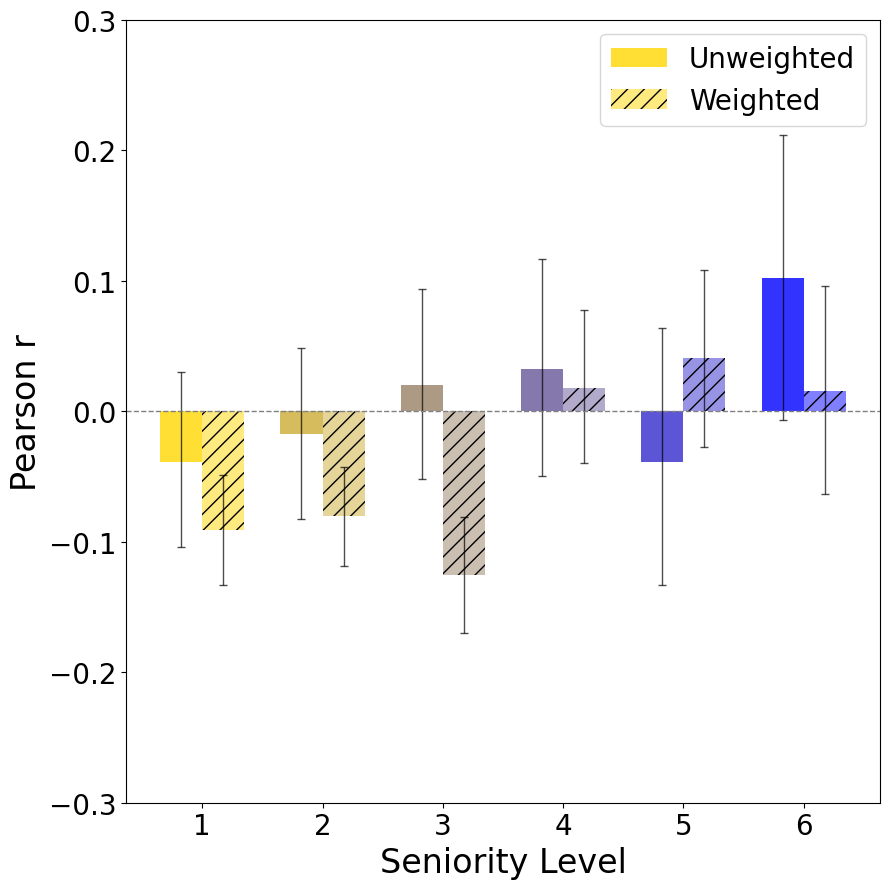

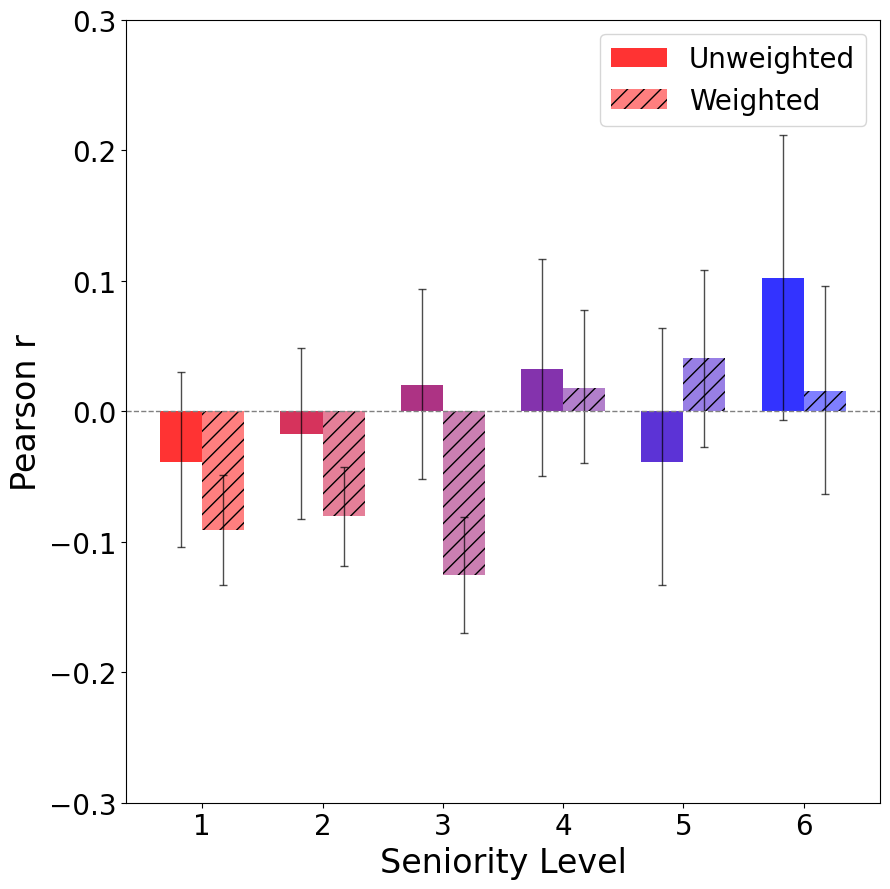


✓ Plots saved to: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 4/Images

FINAL SUMMARY: EU


,seniority,unweighted_mc_median,unweighted_ci_lower,unweighted_ci_upper,unweighted_mc_se,n,weighted_mc_median,weighted_ci_lower,weighted_ci_upper,weighted_mc_se
0,1,-0.038793,-0.104239,0.029825,0.034435,616,-0.090884,-0.133013,-0.048458,0.021829
1,2,-0.017501,-0.082546,0.048597,0.033684,595,-0.080205,-0.118872,-0.042867,0.019234
2,3,0.019899,-0.051740,0.093442,0.037112,438,-0.125654,-0.169804,-0.080935,0.022861
3,4,0.032725,-0.049551,0.116477,0.041925,403,0.018030,-0.039476,0.077703,0.029954
4,5,-0.038928,-0.133207,0.063877,0.049009,395,0.040564,-0.027562,0.108421,0.034976
5,6,0.102142,-0.006462,0.211888,0.054887,196,0.015904,-0.063495,0.096417,0.040793



FINAL SUMMARY: USA


,seniority,unweighted_mc_median,unweighted_ci_lower,unweighted_ci_upper,unweighted_mc_se,n,weighted_mc_median,weighted_ci_lower,weighted_ci_upper,weighted_mc_se
0,1,-0.038793,-0.104239,0.029825,0.034435,616,-0.090884,-0.133013,-0.048458,0.021829
1,2,-0.017501,-0.082546,0.048597,0.033684,595,-0.080205,-0.118872,-0.042867,0.019234
2,3,0.019899,-0.051740,0.093442,0.037112,438,-0.125654,-0.169804,-0.080935,0.022861
3,4,0.032725,-0.049551,0.116477,0.041925,403,0.018030,-0.039476,0.077703,0.029954
4,5,-0.038928,-0.133207,0.063877,0.049009,395,0.040564,-0.027562,0.108421,0.034976
5,6,0.102142,-0.006462,0.211888,0.054887,196,0.015904,-0.063495,0.096417,0.040793


In [ ]:
# Visualize weighted vs unweighted correlations side by side
from matplotlib.colors import LinearSegmentedColormap
import os

# Create output directory if it doesn't exist
output_dir = '../Results'
os.makedirs(output_dir, exist_ok=True)

# EU: Yellow to Blue
eu_colors = ['#FFD700', '#0000FF']
eu_cmap = LinearSegmentedColormap.from_list('eu_cmap', eu_colors, N=6)
eu_palette = [eu_cmap(i/5) for i in range(6)]

# USA: Red to Blue
usa_colors = ['#FF0000', '#0000FF']
usa_cmap = LinearSegmentedColormap.from_list('usa_cmap', usa_colors, N=6)
usa_palette = [usa_cmap(i/5) for i in range(6)]


def compute_error_bars(point_col, ci_lower_col, ci_upper_col, df, label=""):
    """
    Compute error bars for matplotlib errorbar, ensuring non-negative values.
    
    Returns: [lower_errors, upper_errors] suitable for yerr parameter
    """
    lower_err = point_col - ci_lower_col
    upper_err = ci_upper_col - point_col
    
    # Handle NaNs
    lower_err = lower_err.fillna(0)
    upper_err = upper_err.fillna(0)
    
    # Check for negative values and provide diagnostics
    if (lower_err < 0).any() or (upper_err < 0).any():
        print(f"\n⚠ Warning: Negative error bars detected in {label}")
        problem_rows = df[(lower_err < 0) | (upper_err < 0)]
        for _, row in problem_rows.iterrows():
            sen = row['seniority']
            idx = df[df['seniority'] == sen].index[0]
            point = point_col.iloc[idx]
            ci_l = ci_lower_col.iloc[idx]
            ci_u = ci_upper_col.iloc[idx]
            l_err = lower_err.iloc[idx]
            u_err = upper_err.iloc[idx]
            print(f"  Seniority {sen}: point={point:.6f}, CI=[{ci_l:.6f}, {ci_u:.6f}], "
                  f"lower_err={l_err:.6f}, upper_err={u_err:.6f}")
        print("  Clipping negative values to 0 for plotting.")
    
    # Clip to ensure non-negative
    lower_err = lower_err.clip(lower=0)
    upper_err = upper_err.clip(lower=0)
    
    return [lower_err.values, upper_err.values]


# EU correlations plot (weighted vs unweighted) with error bars
fig1, ax1 = plt.subplots(figsize=(9, 9))
x = np.arange(1, 7)
width = 0.35

# Compute error bars
errors_unw = compute_error_bars(
    corr_eu_combined['unweighted_mc_median'],
    corr_eu_combined['unweighted_ci_lower'],
    corr_eu_combined['unweighted_ci_upper'],
    corr_eu_combined,
    label="EU unweighted"
)

errors_w = compute_error_bars(
    corr_eu_combined['weighted_mc_median'],
    corr_eu_combined['weighted_ci_lower'],
    corr_eu_combined['weighted_ci_upper'],
    corr_eu_combined,
    label="EU weighted"
)

# Create bars
bars1 = ax1.bar(x - width/2, corr_eu_combined['unweighted_mc_median'], width, 
                color=[eu_palette[i] for i in range(6)], label='Unweighted', alpha=0.8)
bars2 = ax1.bar(x + width/2, corr_eu_combined['weighted_mc_median'], width,
                color=[eu_palette[i] for i in range(6)], label='Weighted', alpha=0.5, hatch='//')

# Add error bars
ax1.errorbar(x - width/2, corr_eu_combined['unweighted_mc_median'], 
             yerr=errors_unw, fmt='none', ecolor='black', capsize=3, capthick=1, 
             linewidth=1, alpha=0.7)
ax1.errorbar(x + width/2, corr_eu_combined['weighted_mc_median'], 
             yerr=errors_w, fmt='none', ecolor='black', capsize=3, capthick=1, 
             linewidth=1, alpha=0.7)

ax1.set_xlabel('Seniority Level', fontsize=24)
ax1.set_ylabel('Pearson r', fontsize=24)
ax1.set_xticks(x)
ax1.set_ylim(-0.3, 0.3)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
ax1.legend(fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'R_800_EU_correlation_weighted_unweighted.pdf'), bbox_inches='tight')
plt.show()

# USA correlations plot (weighted vs unweighted) with error bars
fig2, ax2 = plt.subplots(figsize=(9, 9))

# Compute error bars
errors_unw = compute_error_bars(
    corr_usa_combined['unweighted_mc_median'],
    corr_usa_combined['unweighted_ci_lower'],
    corr_usa_combined['unweighted_ci_upper'],
    corr_usa_combined,
    label="USA unweighted"
)

errors_w = compute_error_bars(
    corr_usa_combined['weighted_mc_median'],
    corr_usa_combined['weighted_ci_lower'],
    corr_usa_combined['weighted_ci_upper'],
    corr_usa_combined,
    label="USA weighted"
)

# Create bars
bars1 = ax2.bar(x - width/2, corr_usa_combined['unweighted_mc_median'], width,
                color=[usa_palette[i] for i in range(6)], label='Unweighted', alpha=0.8)
bars2 = ax2.bar(x + width/2, corr_usa_combined['weighted_mc_median'], width,
                color=[usa_palette[i] for i in range(6)], label='Weighted', alpha=0.5, hatch='//')

# Add error bars
ax2.errorbar(x - width/2, corr_usa_combined['unweighted_mc_median'], 
             yerr=errors_unw, fmt='none', ecolor='black', capsize=3, capthick=1, 
             linewidth=1, alpha=0.7)
ax2.errorbar(x + width/2, corr_usa_combined['weighted_mc_median'], 
             yerr=errors_w, fmt='none', ecolor='black', capsize=3, capthick=1, 
             linewidth=1, alpha=0.7)

ax2.set_xlabel('Seniority Level', fontsize=24)
ax2.set_ylabel('Pearson r', fontsize=24)
ax2.set_xticks(x)
ax2.set_ylim(-0.3, 0.3)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
ax2.legend(fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'R_800_USA_correlation_weighted_unweighted.pdf'), bbox_inches='tight')
plt.show()

print(f"\n✓ Plots saved to: {output_dir}")

# Final summary tables
print("\n" + "="*80)
print("FINAL SUMMARY: EU")
print("="*80)
display(corr_eu_combined)

print("\n" + "="*80)
print("FINAL SUMMARY: USA")
print("="*80)
display(corr_usa_combined)
